In [70]:
# Import libraries
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np


from bs4 import BeautifulSoup

## Top Universities Ranking

Top Universities ranking methodology

- Academic Reputation
- Employer Reputation
- **Faculty/Student Ratio**
- Citations per faculty
- **International Faculty Ratio**
- **International Student Ratio**

In this analysis we will focuse on the International outlook and how it influence university ranking

### Retriving data from TopUniversities web site

In [96]:
BASE_URL = 'https://www.topuniversities.com'
# Make the request
r = requests.get('https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508079297350')
json_result = r.json()

In [97]:
def getUniInfo(URL):
    #International faculty member

    r = requests.get(URL)
    soup = BeautifulSoup(r.text, 'html.parser')
    
    #Extract the div with the intels about the faculty
    facultyDiv  = soup.find("div", class_="faculty-main wrapper col-md-4")
    
    #In the case the data is not on the page
    if facultyDiv is None:
        facultyInt = -1
        facultyTot = -1
    else:
        facultyInt = extract_number(facultyDiv.find("div", class_="inter faculty"))
        facultyTot = extract_number(facultyDiv.find("div", class_="total faculty"))
    
    #Extract the div with the intels about the student

    studentInt = soup.find("div", class_="total inter")
    studentTot = soup.find("div", class_="total student")
    #In the case the data is not on the page
    
    if studentInt is None:
        studentInt = -1
    else:
        studentInt = extract_number(studentInt)
        
    if studentTot is None:
        studentTot = -1
    else:
        studentTot = extract_number(studentTot)
        
    return facultyInt,facultyTot,studentInt,studentTot

def extract_number(t):
    #Answer on how to extract the int out of string found here:
    #https://stackoverflow.com/questions/26825729/extract-number-from-string-python
    
    #In case the faculty doesn't have international faculty member
    if t is None:
        return -1
    
    return int(''.join(filter(str.isdigit, t.find("div", class_="number").text)))

In [98]:
#Building the dataFrame
topU_ranking = pd.DataFrame(columns = ['Rank','Name','Country','Region','FacultyMemberInt','FacultyMemberTot','StudentInt','StudentTot'])

nb = 0
for i in json_result.keys():
    for x in json_result[i]:
        
        if nb == 200:
            break
        
        #print(x['title'])
        nb = nb + 1
        facultyInt,facultyTot,studentInt,studentTot = getUniInfo(BASE_URL + x['url'])
        current_uni = [x['rank_display'],x['title'],x['country'],x['region'],facultyInt,facultyTot,studentInt,studentTot]
        topU_ranking.loc[len(topU_ranking)] = current_uni
    

In [111]:
def getBestRatio(data,col1,col2,Mode="MAXIMIZE"):
    """Compute and return the best ratio col1 / col2.FilteringBy indicate the column header we want to filter by"""
    if Mode == 'MAXIMIZE':
        bestRatio = 0
        bestName = ''
    elif Mode == 'MINIMIZE':
        bestRatio = 100
        bestName = ''
    else:
        return -1,"Mode should be MINIMIZE or MAXIMIZE"
    
    ratios = pd.DataFrame(columns = ['Name','Ratio'])
    
    for index, row in data.iterrows():

        currentRatio = (row[col1] / row[col2])
        ratios.loc[len(ratios)] = [row['Name'],currentRatio]
    
        if Mode=="MAXIMIZE" and row[col1] > 0 and row[col2] > 0:
            if bestRatio < currentRatio:
                bestRatio = currentRatio
                bestName = row['Name']
        elif Mode=="MINIMIZE" and row[col1] > 0 and row[col2] > 0:
            if bestRatio > currentRatio:
                bestRatio = currentRatio
                bestName = row['Name']
    ratios = ratios.set_index(['Name'])
    
    return bestName,bestRatio,ratios

def extract_number(t):
    #Answer on how to extract the int out of string found here:
    #https://stackoverflow.com/questions/26825729/extract-number-from-string-python
    
    #In case the faculty doesn't have international faculty member
    if t is None:
        return -1
    
    return int(''.join(filter(str.isdigit, t)))

In [112]:
#Get the best ratio of international faculty member.
uniWithBestFacRatio, maxIntFacRatio, FacByStudRatio = getBestRatio(topU_ranking,'FacultyMemberTot','StudentTot')
print("Best ratio between faculty members and students:\n Name = {n}, Ratio = {r}".format(n=uniWithBestFacRatio,r=maxIntFacRatio))   

#Get the best ratio of international student.
uniWithBestStudRatio, maxIntStudRatio, IntStudRatio  = getBestRatio(topU_ranking,'StudentInt','StudentTot')
print("Best ratio of international student:\n Name = {n}, Ratio = {r}".format(n=uniWithBestStudRatio,r=maxIntStudRatio)) 

Best ratio between faculty members and students:
 Name = California Institute of Technology (Caltech), Ratio = 0.42261640798226163
Best ratio of international student:
 Name = London School of Economics and Political Science (LSE), Ratio = 0.6913934426229508


### The best Ratio by Country

In [113]:
#Get the list of the countries in the dataFrame
countryStats = pd.DataFrame(columns = ['Name','FacultyMemberInt','FacultyMemberTot','StudentInt','StudentTot'])
countries = topU_ranking.Country.unique()

for country in countries:
    
    #Ignore the row with -1
    currentCountry = topU_ranking[(topU_ranking.Country == country)&(topU_ranking.StudentInt >=0)&(topU_ranking.StudentTot >=0)&(topU_ranking.FacultyMemberInt >=0)&(topU_ranking.FacultyMemberTot >=0)]
    
    #Sum the columns
    IntStud = currentCountry.StudentInt.sum()
    TotStud = currentCountry.StudentTot.sum()
    IntFac = currentCountry.FacultyMemberInt.sum()
    TotFac = currentCountry.FacultyMemberTot.sum()
    
    currentCountry = [country,IntFac,TotFac,IntStud,TotStud]
    countryStats.loc[len(countryStats)] = (currentCountry)
    
CountryWithBestFacRatio, maxIntFacCountryRatio, FacByStudRatioCountry = getBestRatio(countryStats,'FacultyMemberInt','FacultyMemberTot','MINIMIZE')
print("Best ratio between faculty members and students:\nName = {n}, Ratio = {r}".format(n=CountryWithBestFacRatio,r=maxIntFacCountryRatio)) 

CountryWithBestStudRatio, maxIntStudCountryRatio, IntStudRatioCountry = getBestRatio(countryStats,'StudentInt','StudentTot')
print("Best ratio of international student:\nName = {n}, Ratio = {r}".format(n=CountryWithBestStudRatio,r=maxIntStudCountryRatio)) 

Best ratio between faculty members and students:
Name = India, Ratio = 0.01713859910581222
Best ratio of international student:
Name = Australia, Ratio = 0.3521891163400597


### The best Ratio by Region

In [114]:
#Get the list of the countries in the dataFrame
RegionStats = pd.DataFrame(columns = ['Name','FacultyMemberInt','FacultyMemberTot','StudentInt','StudentTot'])
regions = topU_ranking.Region.unique()

for region in regions:
    
    #Delete the row with -1
    currentRegion = topU_ranking[(topU_ranking.Region == region)&(topU_ranking.StudentInt >=0)&(topU_ranking.StudentTot >=0)&(topU_ranking.FacultyMemberInt >=0)&(topU_ranking.FacultyMemberTot >=0)]
    
    #Sum the columns
    IntStud = currentRegion.StudentInt.sum()
    TotStud = currentRegion.StudentTot.sum()
    IntFac = currentRegion.FacultyMemberInt.sum()
    TotFac = currentRegion.FacultyMemberTot.sum()
    
    currentRegion = [region,IntFac,TotFac,IntStud,TotStud]
    RegionStats.loc[len(RegionStats)] = (currentRegion)
    
RegionWithBestFacRatio, maxIntFacRegionRatio, FacByStudRatioRegion = getBestRatio(RegionStats,'FacultyMemberTot','StudentTot','MINIMIZE')
print("Best ratio between faculty members and students:\nName = {n}, Ratio = {r}".format(n=RegionWithBestFacRatio,r=maxIntFacRegionRatio)) 

RegionWithBestStudRatio, maxIntStudRegionRatio, IntStudRatioRegion = getBestRatio(RegionStats,'StudentInt','StudentTot')
print("Best ratio of international student:\nName = {n}, Ratio = {r}".format(n=RegionWithBestStudRatio,r=maxIntStudRegionRatio)) 

Best ratio between faculty members and students:
Name = Oceania, Ratio = 0.07238546179394403
Best ratio of international student:
Name = Oceania, Ratio = 0.3392609811889755


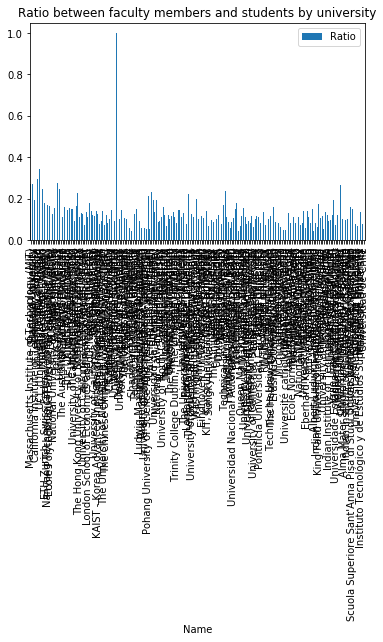

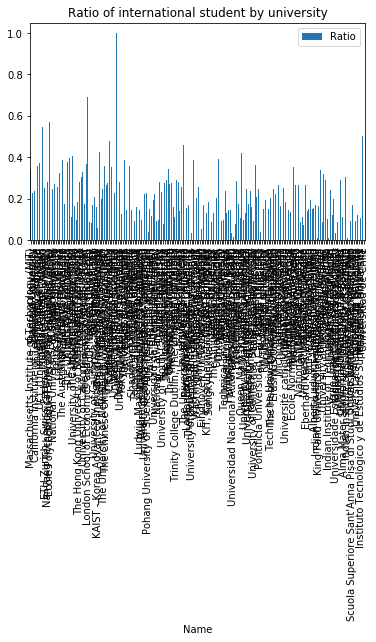

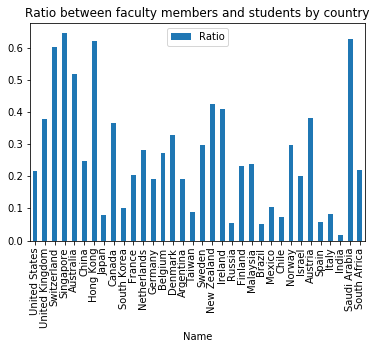

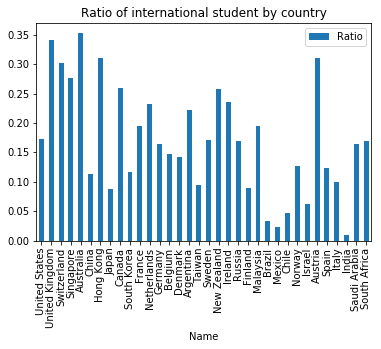

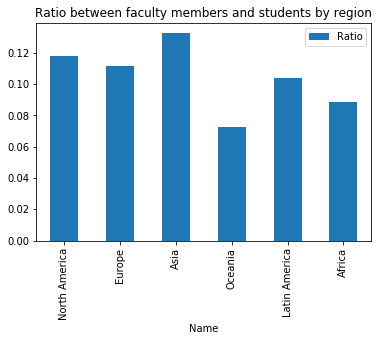

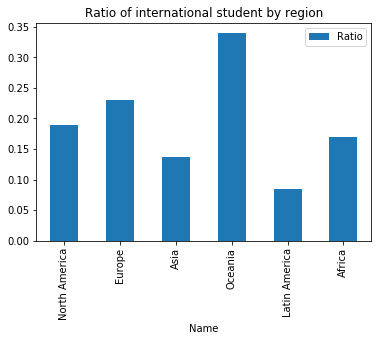

In [120]:
FacByStudRatio.plot(kind='bar') 
plt.title('Ratio between faculty members and students by university') 
plt.legend(['Ratio']) 
plt.show() 
      
IntStudRatio.plot(kind='bar') 
plt.title('Ratio of international student by university') 
plt.legend(['Ratio']) 
plt.show() 

FacByStudRatioCountry.plot(kind='bar') 
plt.title('Ratio between faculty members and students by country') 
plt.legend(['Ratio']) 
plt.show() 
      
IntStudRatioCountry.plot(kind='bar') 
plt.title('Ratio of international student by country') 
plt.legend(['Ratio']) 
plt.show() 
      
FacByStudRatioRegion.plot(kind='bar') 
plt.title('Ratio between faculty members and students by region') 
plt.legend(['Ratio']) 
plt.show() 
      
IntStudRatioRegion.plot(kind='bar') 
plt.title('Ratio of international student by region') 
plt.legend(['Ratio']) 
plt.show() 

## Times Higher Education Ranking

Times Higher Education Ranking methodology: 
    
The performance indicators are grouped into five areas:

- Teaching (the learning environment)
- Research (volume, income and reputation)
- Citations (research influence);
- **International outlook (staff, students and research)**
- Industry income (knowledge transfer)

### Retreiving Data From timeshighereducation website:

In [78]:
API_URL_DATA = "https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json"#Building the dataFrame
json_result = requests.get(API_URL_DATA).json()["data"]
times_ranking = pd.DataFrame(columns = ['Rank','Name','Country','FacultyMemberTot','StudentInt','StudentTot'])
nb = 0
for x in json_result:        
    if nb == 200:
        break        
    studentTot = extract_number(x['stats_number_students']) 
    studentInt = int(extract_number(x['stats_pc_intl_students'])*studentTot/100)
    facultyTot = int(studentTot/float(x['stats_student_staff_ratio']))
    current_uni = [x['rank'],x['name'],x['location'],facultyTot,studentInt,studentTot]
    times_ranking.loc[nb] = current_uni
    nb = nb + 1

In [79]:
# a) Get the best ratio between faculty members and students,
uniWithBestRatio, maxRatio = getBestRatio(times_ranking,'StudentTot','FacultyMemberTot','MINIMIZE')
print("Best ratio between faculty members and students:\n  Name = {n}, Ratio 'number of students per staff' = {r}".format(n=uniWithBestRatio,r=maxRatio))   

# b) Get the best ratio of international student.
uniWithBestStudRatio, maxIntStudRatio = getBestRatio(times_ranking,'StudentInt','StudentTot')
print("Best ratio of international student:\n  Name = {n}, Ratio = {r}".format(n=uniWithBestStudRatio,r=maxIntStudRatio)) 

Best ratio between faculty members and students:
  Name = Vanderbilt University, Ratio 'number of students per staff' = 3.300632041769717
Best ratio of international student:
  Name = London School of Economics and Political Science, Ratio = 0.7099850968703427


### The best Ratio by Country

In [80]:
#Get the list of the countries in the dataFrame
countryStats = pd.DataFrame(columns = ['Name','FacultyMemberTot','StudentInt','StudentTot'])
countries = times_ranking.Country.unique()

for country in countries:
    
    #Delete the row with -1
    currentCountry = times_ranking[(times_ranking.Country == country)&(times_ranking.StudentInt >=0)&(times_ranking.StudentTot >=0)&(times_ranking.FacultyMemberTot >=0)]
    
    #Sum the columns
    IntStud = currentCountry.StudentInt.sum()
    TotStud = currentCountry.StudentTot.sum()
    TotFac = currentCountry.FacultyMemberTot.sum()
    
    currentCountry = [country,TotFac,IntStud,TotStud]
    countryStats.loc[len(countryStats)] = (currentCountry)

# a) Get the best ratio between faculty members and students by country
CountryWithBestFacRatio, maxIntFacCountryRatio = getBestRatio(countryStats,'StudentTot','FacultyMemberTot','MINIMIZE')
print("Best ratio between faculty members and students by country:\n  Name = {n}, Ratio 'number of students per staff' = {r}".format(n=CountryWithBestFacRatio,r=maxIntFacCountryRatio)) 

# b) Get the best ratio of international student by country
CountryWithBestStudRatio, maxIntStudCountryRatio = getBestRatio(countryStats,'StudentInt','StudentTot')
print("Best ratio of international student vy country:\n  Name = {n}, Ratio = {r}".format(n=CountryWithBestStudRatio,r=maxIntStudCountryRatio)) 

Best ratio between faculty members and students by country:
  Name = Denmark, Ratio 'number of students per staff' = 6.05039637599094
Best ratio of international student vy country:
  Name = Luxembourg, Ratio = 0.5699335882471323


## Merging Both Ranking

In [81]:
# Matching universities'names
for i in range(0,len(topU_ranking)):
    test = topU_ranking["Name"][i]
    if( test.find("(") != -1 and test.find(")") != -1):
        extract = test[test.find("(")+1:test.find(")")]
        if(2*len(extract) < len(test)):
            test = test.replace("("+extract+")","")  
        else:
            test = extract
    topU_ranking["Name"][i]=test

In [82]:
topU_ranking = topU_ranking.set_index(['Name'])
times_ranking = times_ranking.set_index(["Name"])

In [83]:
def country_notNull(row):
    cx = row["Country_x"]
    cy = row["Country_y"]
    if not pd.isnull(cy) :
        return cy
    return cx

In [84]:
times_TopU_ranking = pd.merge(topU_ranking,times_ranking,how="inner",left_index=True,right_index=True)
times_TopU_ranking["Country"] = times_TopU_ranking.apply(country_notNull, axis=1) 

#avg data
times_TopU_ranking["FacultyMemberTot"] =  (times_TopU_ranking["FacultyMemberTot_x"]+times_TopU_ranking["FacultyMemberTot_y"])/2
times_TopU_ranking["StudentTot"] =  (times_TopU_ranking["StudentTot_x"]+times_TopU_ranking["StudentTot_y"])/2
times_TopU_ranking["StudentInt"] =  (times_TopU_ranking["StudentInt_x"]+times_TopU_ranking["StudentInt_y"])/2


times_TopU_ranking.drop(["Country_x","Country_y","StudentInt_y","StudentTot_y","FacultyMemberTot_y","FacultyMemberTot_x","StudentInt_x","StudentTot_x"], axis=1, inplace=True) #drop country_x & country_y
times_TopU_ranking.rename(columns={'Rank_x': 'Times_Ranking', 'Rank_y': 'TopU_Ranking',}, inplace=True)
times_TopU_ranking = times_TopU_ranking[["Times_Ranking","TopU_Ranking","Country","Region","FacultyMemberTot","FacultyMemberInt","StudentTot","StudentInt"]]

In [85]:
#Searching a correlation between the international dimension and the ranking
data = pd.DataFrame(columns = ['Times_Ranking','TopU_Ranking','InternationalStudRatio','InternationalFacRatio'])

for index, row in times_TopU_ranking.iterrows():
    current_rank_times = row['Times_Ranking']
    if '=' in current_rank_times[:1]:
        current_rank_times = current_rank_times[1:]
        
    current_rank_U = row['TopU_Ranking']
    if '=' in current_rank_U[:1]:
        current_rank_U = current_rank_U[1:]
    
    current_stud_ratio = row['StudentInt'] / row['StudentTot']
    current_fac_ratio = row['FacultyMemberInt'] / row['FacultyMemberTot']
    current_row = [current_rank_times,current_rank_U,current_stud_ratio,current_fac_ratio]
    data.loc[len(data)] = current_row

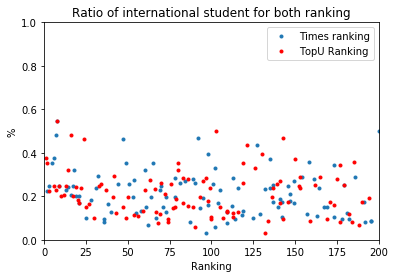

In [86]:
plt.plot(data['Times_Ranking'],data['InternationalStudRatio'],'.',data['TopU_Ranking'],data['InternationalStudRatio'],'r.')
plt.axis([0, 200, 0, 1])
plt.title('Ratio of international student for both ranking')
plt.xlabel('Ranking')
plt.legend(["Times ranking","TopU Ranking"])
plt.ylabel('%')
plt.show()

Wee see that ratio of international student for the top 20 university is at least greater than 0.2

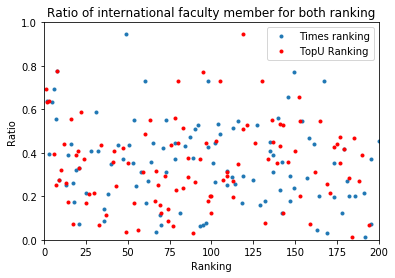

In [117]:
plt.plot(data['Times_Ranking'],data['InternationalFacRatio'],'.',data['TopU_Ranking'],data['InternationalFacRatio'],'r.')
plt.axis([0, 200, 0, 1])
plt.title('Ratio of international faculty member for both ranking')
plt.xlabel('Ranking')
plt.legend(["Times ranking","TopU Ranking"])
plt.ylabel('Ratio')
plt.show()

We can clearly see that the top5 university has a ratio of international faculty member greater than 0.6

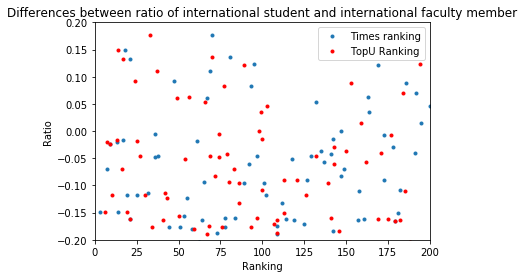

In [116]:
plt.plot(data['Times_Ranking'],data['InternationalStudRatio'] - data['InternationalFacRatio'],'.',data['TopU_Ranking'],data['InternationalStudRatio'] - data['InternationalFacRatio'],'r.')
plt.axis([0, 200, -0.2, 0.2])
plt.title('Differences between ratio of international student and international faculty member')
plt.xlabel('Ranking')
plt.ylabel('Ratio')
plt.legend(["Times ranking","TopU Ranking"])

plt.show()

In [89]:
times_TopU_ranking.head()

,Times_Ranking,TopU_Ranking,Country,Region,FacultyMemberTot,FacultyMemberInt,StudentTot,StudentInt
Name,,,,,,,,
Stanford University,2,=3,United States,North America,3198.5,2042,15861.5,3548
Harvard University,3,6,United States,North America,3316.5,1311,21377.5,5275
University of Cambridge,5,2,United Kingdom,Europe,3588.5,2278,18579.5,6567.5
University of Oxford,6,1,United Kingdom,Europe,4286,2964,20064.5,7554
University College London,7,16,United Kingdom,Europe,4615.5,2554,30692,14851


### The best university according to both ranking is : Stanford University

( minimum of times.ranking^2 + topU.ranking^2)